In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold

# Experiment 1

Aim: understanding the change of energy as the step size changes. 

- Same starting point on ellipse for both Hug and THug
- No accept reject step 
- Fixed number of steps $B$, only one iteration of the algorithm.
- Use same velocities drawn from a spherical distribution

#### Function Running Hug and THug

In [172]:
def NoAR(x00, T, B, n, alphas, q_sample, logq, logpi, grad_log_pi):
    """
    Hug and THug without Accept-Reject.
    """
    v_sphericals = np.vstack([q_sample() for _ in range(n)])
    t_finals = np.zeros((len(alphas), 2))
    ### HUG
    x0 = x00
    for i in range(n):
        # Draw velocity
        v0 = v_sphericals[i]
        
        # Housekeeping
        v = v0
        x = x0
        # Compute step size
        delta = T / B

        for _ in range(B):
            # Move
            x = x + delta*v/2 
            # Reflect
            g = grad_log_pi(x)
            ghat = g / norm(g)
            v = v - 2*(v @ ghat) * ghat
            # Move
            x = x + delta*v/2
        x0 = x
    h_final = x
    ### THUG
    for ix, alpha in enumerate(alphas):
        x0 = x00
        for i in range(n):
            # Draw velocity spherically
            v0s = v_sphericals[i]
            # Compute normalized gradient at x0
            g = grad_log_pi(x0)
            g = g / norm(g)
            # Tilt velocity
            v0 = v0s - alpha * g * (g @ v0s)
            # Housekeeping
            v = v0
            x = x0
            # Compute step size
            delta = T / B

            for _ in range(B):
                # Move
                x = x + delta*v/2 
                # Reflect
                g = grad_log_pi(x)
                ghat = g / norm(g)
                v = v - 2*(v @ ghat) * ghat
                # Move
                x = x + delta*v/2
            x0 = x
        t_finals[ix] = x
    return h_final, t_finals   # Grab only final point for Hug, grab final points for each α for THUG

In [213]:
# Settings
z = 0.02       # Contour-value
beta = 1.0     # "Global" scaling for the spherical proposal
alpha = 0.95   # Proportion of gradient to remove from spherical proposal in THUG
T = 0.5        # Integration time
B = 1          # Number of bounces per iteration
n = 100          # Total number of iterations of Hug/THug
m = 50         # Number of times to average distances over for each setting

In [214]:
# Random Initial point on contour.
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
x0 = RotatedEllipse(mu, Sigma, z).to_cartesian(np.random.uniform(0, 2*np.pi))

In [215]:
# Target is just the MVN whose contour we are sampling
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)

In [216]:
hsample, tsamples = NoAR(x0, T, B, n, alphas, q.rvs, q.logpdf, logpi, grad_log_pi)

In [220]:
betas = np.arange(0.1, 20, 0.5)
alphas = np.round(np.arange(0.05, 1.0, 0.15), decimals=2)
h_distances = []
t_distances = np.zeros((len(betas), len(alphas)))
for ix, beta in enumerate(betas):
    # Set new proposal 
    q = multivariate_normal(mean=np.zeros(2), cov=beta*np.eye(2))
    h_dists = 0.0
    t_dists = np.zeros_like(alphas)
    for j in range(m):
        hsample, tsamples = NoAR(x0, T, B, n, alphas, q.rvs, q.logpdf, logpi, grad_log_pi)
        h_dists += np.abs(target.logpdf(hsample) - np.log(z))
        t_dists += np.abs(target.logpdf(tsamples) - np.log(z))
    h_distances.append(h_dists / m)
    t_distances[ix] = t_dists / m

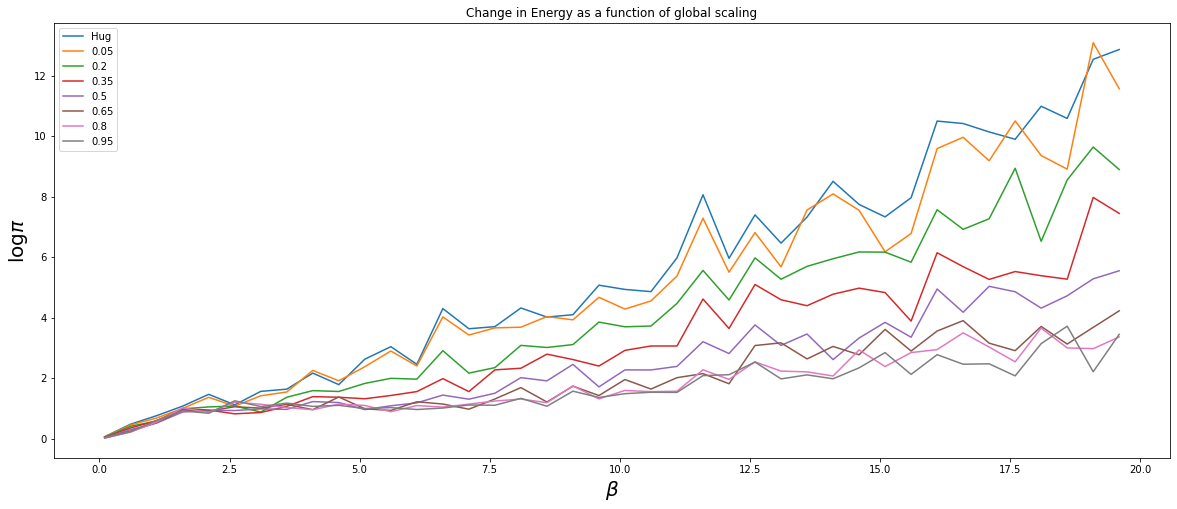

In [221]:
fig, ax = plt.subplots(figsize=(20, 8))
hug = ax.plot(betas, h_distances, label="Hug")
thug = ax.plot(betas, t_distances)
ax.set_xlabel(r'$\beta$', fontsize=20)
ax.set_ylabel(r'$\log\pi$', fontsize=20)
ax.set_title("Change in Energy as a function of global scaling")
ax.legend(hug + thug,  ["Hug"] + alphas.tolist())
plt.show()